In [72]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

**Codice generazione forme singole**

In [73]:
def to_stringa(punti, forma):
    return ";".join(f"{x:.3f}:{y:.3f}" for x, y in punti)+','+forma

def genera_segmento(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Calcola le coordinate dei due estremi del segmento
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    # Interpolazione lineare tra i due estremi per ottenere i punti
    t = np.linspace(0, 1, n_punti)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    # Aggiunta di rumore gaussiano alle coordinate
    x += np.random.normal(0, rumore_std, size=n_punti)
    y += np.random.normal(0, rumore_std, size=n_punti)
    # Restituisce un array Nx2 con i punti generati
    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)

def genera_croce(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Primo segmento (angolo theta)
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    t = np.linspace(0, 1, n_punti//2)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    x += np.random.normal(0, rumore_std, size=n_punti//2)
    y += np.random.normal(0, rumore_std, size=n_punti//2)

    # Secondo segmento (angolo theta + 90°)
    x1 = x0 - l * np.sin(theta)
    y1 = y0 + l * np.cos(theta)
    x2 = x0 + l * np.sin(theta)
    y2 = y0 - l * np.cos(theta)
    t = np.linspace(0, 1, n_punti//2)
    xx = x1 + t * (x2 - x1)
    yy = y1 + t * (y2 - y1)
    xx += np.random.normal(0, rumore_std, size=n_punti//2)
    yy += np.random.normal(0, rumore_std, size=n_punti//2)

    # Unisce i punti dei due segmenti
    x = np.concatenate([x, xx])
    y = np.concatenate([y, yy])

    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)



def genera_ellisse(a=1.0, b=0.5, centro=(0, 0), angolo=0.0, n_punti=100, rumore_std=0.0):
    t = np.linspace(0, 2 * np.pi, n_punti)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Rotazione
    x_rot = x * np.cos(angolo) - y * np.sin(angolo)
    y_rot = x * np.sin(angolo) + y * np.cos(angolo)

    # Traslazione
    x_finale = x_rot + centro[0]
    y_finale = y_rot + centro[1]

    # Rumore
    x_finale += np.random.normal(0, rumore_std, size=n_punti)
    y_finale += np.random.normal(0, rumore_std, size=n_punti)

    return np.stack([x_finale, y_finale], axis=1)


def genera_rettangolo(larghezza=1.0, altezza=0.5, centro=(0, 0), angolo=0.0,
            rumore_std=0.0, n_punti=100):
    if n_punti < 4:
        raise ValueError("n_punti deve essere almeno 4")

    # Vertici base
    w, h = larghezza / 2, altezza / 2
    vertici = np.array([
        [-w, -h],
        [ w, -h],
        [ w,  h],
        [-w,  h]
    ])

    # Lati e lunghezze
    lati = [(vertici[(i+1) % 4] - vertici[i]) for i in range(4)]
    lunghezze = np.array([np.linalg.norm(l) for l in lati])
    proporzioni = lunghezze / lunghezze.sum()

    # Distribuzione dei punti
    n_per_lato = np.floor(proporzioni * n_punti).astype(int)
    restante = n_punti - n_per_lato.sum()
    for i in range(restante):
        n_per_lato[i % 4] += 1

    # Generazione dei punti
    punti = []
    for i, n in enumerate(n_per_lato):
        start = vertici[i]
        end = vertici[(i + 1) % 4]
        t_values = np.linspace(0, 1, n, endpoint=False)
        lato = np.outer(1 - t_values, start) + np.outer(t_values, end)
        punti.append(lato)
    punti = np.vstack(punti)

    # Rotazione, traslazione e rumore
    R = np.array([
        [np.cos(angolo), -np.sin(angolo)],
        [np.sin(angolo),  np.cos(angolo)]
    ])
    punti = punti @ R.T
    punti += np.array(centro)
    punti += np.random.normal(0, rumore_std, punti.shape)

    return punti

__**Generazione intero dataset**__

In [74]:
def genera_campioni(n_shapes = 100, n_punti = 50, rumore_std_bound=0):

    X, y = [], []  # Liste per memorizzare i campioni e le etichette

    # Genera ellissi
    for _ in range(n_shapes):
        a = np.random.uniform(0.5, 3.0)                  # semiasse maggiore
        b = np.random.uniform(0.3, a)                    # semiasse minore
        centro = (np.random.uniform(-5, 5), np.random.uniform(-5, 5))  # centro casuale
        angolo = np.random.uniform(0, 2 * np.pi)         # rotazione casuale
        rumore = np.random.uniform(0.0, rumore_std_bound)  # rumore casuale
        punti = genera_ellisse(a, b, centro, angolo, n_punti=n_punti, rumore_std=rumore)  # genera punti
        X.append(punti)
        y.append(0)  # 0 = ellisse

    # Genera rettangoli
    for _ in range(n_shapes):
        punti = genera_rettangolo(
            larghezza=np.random.uniform(0.5, 3.0),       # larghezza casuale
            altezza=np.random.uniform(0.5, 2.0),         # altezza casuale
            centro=(np.random.uniform(-5, 5), np.random.uniform(-5, 5)),  # centro casuale
            angolo=np.random.uniform(0, 2*np.pi),        # rotazione casuale
            rumore_std = np.random.uniform(0.0, rumore_std_bound),        # rumore casuale
            n_punti = n_punti
        )
        X.append(punti)
        y.append(1) # 1 = rettangolo

    # Genera segmenti
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_segmento(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(2)
        
    # Genera croci (due segmenti ortogonali)
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_croce(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(3)  # 3 = croce
        
    return np.array(X), np.array(y)  # restituisce array di campioni e etichette

In [75]:
labels = ['ellisse', 'rettangolo', 'segmento', 'croce']

*______________________________________________________________________________________________________________________________________________________*

**Generazione e splitting Dataset**

In [76]:
X, y = genera_campioni(n_shapes=1000, n_punti=100, rumore_std_bound=0.1)

In [77]:
X_f = np.array([shape.flatten() for shape in X])

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X_f, y, test_size=0.2, random_state=42, stratify=y
)

**Standardizzazione**

In [79]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

**USO DI PANDAS PER ESPORTAZIONE CSV**

* Struttura tabellare: ogni colonna è chiaramente un campo (x0, y0, x1, y1, …, label).


* Pandas: ti permette di fare subito operazioni su DataFrame, visualizzare, filtrare, raggruppare, etc.


In [80]:

def esporta_dataset_train(filename, X_train_std, y_train, label_names=None):
    # appiattisci
    X_flat = [x.flatten() for x in X_train_std]
    # genera colonne x0,y0,x1,y1,...
    cols = []
    for i in range(len(X_flat[0])//2):
        cols += [f'x{i}', f'y{i}']
    # costruisci DataFrame
    df = pd.DataFrame(X_flat, columns=cols)
    # aggiungi label, numerica o testuale
    if label_names is not None:
        df['label'] = [label_names[int(lbl)] for lbl in y_train]
    else:
        df['label'] = y_train
    # esporta
    df.to_csv(filename, index=False)
    
def esporta_dataset_test(filename, X_test_std, y_test, label_names=None):
    # appiattisci
    X_flat = [x.flatten() for x in X_test_std]
    # genera colonne x0,y0,x1,y1,...
    cols = []
    for i in range(len(X_flat[0])//2):
        cols += [f'x{i}', f'y{i}']
    # costruisci DataFrame
    df = pd.DataFrame(X_flat, columns=cols)
    # aggiungi label, numerica o testuale
    if label_names is not None:
        df['label'] = [label_names[int(lbl)] for lbl in y_test]
    else:
        df['label'] = y_test
    # esporta
    df.to_csv(filename, index=False)

In [81]:

esporta_dataset_train('dataset_train.csv', X_train_std, y_train, label_names=labels)
esporta_dataset_test('dataset_test.csv', X_test_std, y_test, label_names=labels)

In [82]:
print("Shape di X:", X_train_std.shape)
print("Shape di y:", y.shape)

Shape di X: (3200, 200)
Shape di y: (4000,)


*______________________________________________________________________________________________________________________________________________________*

In [83]:
def get_eigen(A):
    # calcola la media per ogni colonna (feature)
    means = np.mean(A, axis=0)
    # sottrae la media (lungo le colonne): ogni feature ora ha media zero
    M = (A - means)
    # calcola la matrice di covarianza delle righe di A
    c = np.cov(M, rowvar=0)
    # calcola autovalori e autovettori della matrice di covarianza
    [evals, evects] = np.linalg.eig(c)
    # ottiene gli indici degli autovalori ordinati in modo decrescente
    idx = np.argsort(evals)[::-1]
    # ordina gli autovettori (colonne di evects) secondo gli autovalori ordinati
    evects = evects[:, idx]
    # ordina gli autovalori in modo decrescente
    evals = evals[idx]
    return evals, evects, M

In [84]:
def pca(M, vec, numpc=0):
    # Estrae i primi 'numpc' autovettori come base dello spazio ridotto
    basis = vec[:, range(numpc)]
    # Proietta i dati centrati nello spazio delle componenti principali
    projections = np.dot(M, basis)
    # Restituisce la base e le proiezioni
    return basis, projections

In [85]:
evals, evects, M_train = get_eigen(X_train_std)

In [90]:
numpc = 10         
basis, scores_train = pca(M_train, evects, numpc)

In [91]:
var_ratio = evals / evals.sum()
print("Explained variance ratio per PC:", var_ratio[:numpc])
print("Total explained variance (%d PC):" % numpc, var_ratio[:numpc].sum())

Explained variance ratio per PC: [4.69657534e-01 4.54071936e-01 2.84811968e-02 2.54657943e-02
 6.68888184e-03 5.56025174e-03 4.95747078e-03 4.35920821e-03
 1.66042029e-04 1.59449477e-04]
Total explained variance (10 PC): 0.9995677653694989


*Tenendo 4 PC, si riduce la dimensionalità da 200 a 4 mantenendo il 97 % dell’informazione (varianza) originale. È un ottimo compromesso tra riduzione di complessità e preservazione dei dati.*

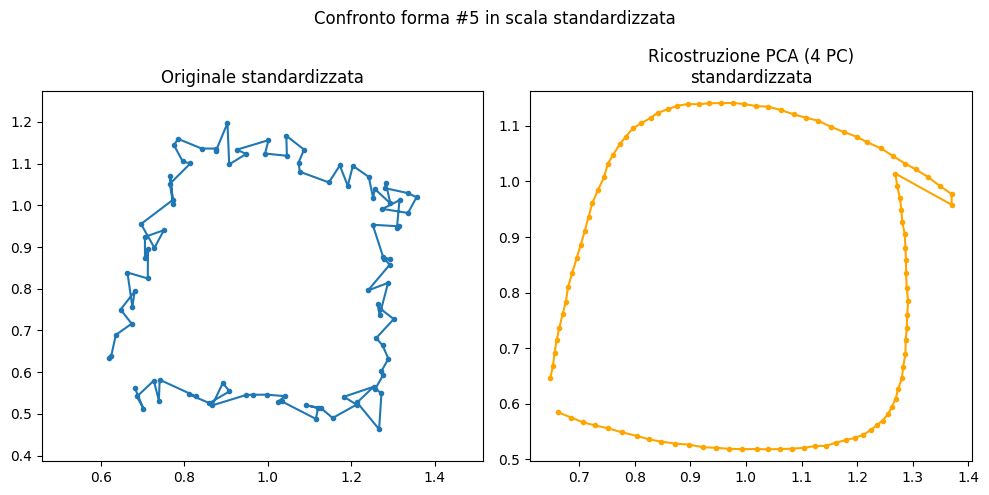

In [92]:
# — Assicuriamoci di avere già:
# X_f    = ottieni_features(X)                # vettori raw
# scaler = StandardScaler().fit(X_f)
# X_std  = scaler.transform(X_f)              # shape (n_samples, n_features)
# evals, evects, M = get_eigen(X_std)         # PCA manuale
# basis, scores   = pca(M, evects, numpc=4)   # basis (n_features×4), scores (n_samples×4)

# Scegli l’indice da mostrare
i = 5

# Forma originalizzata nella scala standardizzata
orig_std = X_train_std[i]              # vettore di lunghezza n_features
orig_pts  = orig_std.reshape(-1, 2)

# Ricostruzione PCA nella scala standardizzata
recon_std = scores_train[i].dot(basis.T)  # shape (n_features,)
recon_pts  = recon_std.reshape(-1, 2)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(orig_pts[:,0], orig_pts[:,1], '-o', markersize=3)
ax1.set_title("Originale standardizzata")
ax1.axis('equal')

ax2.plot(recon_pts[:,0], recon_pts[:,1], '-o', markersize=3, color='orange')
ax2.set_title(f"Ricostruzione PCA (4 PC)\nstandardizzata")
ax2.axis('equal')

plt.suptitle(f"Confronto forma #{i} in scala standardizzata")
plt.tight_layout()
plt.show()


* A destra notiamo la ricostruzione della forma utilizzando solo 4 componenti, cioè un vettore di 200 coordinate ottenuto dalla somma pesata di 4 basi